In [1]:

#%%
# path to working directory
path = '/Users/davidnordfors/galvanize/galvanize-capstone/final'

# IMPORT LIBRARIES
## OS
import os
os.chdir(path)

# MANAGE
import pandas as pd
import numpy as np
#from collections import Counter
from boolma import BM

## FIT
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

## DECOMPOSITION
from sklearn.decomposition import NMF
from scipy.linalg import svd

## GRAPHICS
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

def dist_boxplot(x, **kwargs):
    ax = sns.distplot(x, hist_kws=dict(alpha=0.2))
    ax2 = ax.twinx()
    sns.boxplot(x=x, ax=ax2)
    ax2.set(ylim=(-5, 5))


#%% DATA
## I/O
import zipfile
import requests
import pickle

# Normalization function
def norm(vec):
    return (vec-vec.mean())/vec.std()

# READ O*NET DATABASE. Search order: Dictionary, Pickle, Excel; Create dictionary/pickle if non-existent.
onet = {}
def from_onet(qualities):
        if qualities in onet:
                return onet[qualities]
        pickle_exists = os.path.isfile('./data/pickle/'+qualities+'.pkl')
        if pickle_exists:
                onet[qualities] = pd.read_pickle('./data/pickle/'+qualities+'.pkl')
                return onet[qualities]
        else: 
                onet[qualities]= pd.read_excel(
                        zipfile.ZipFile('./data/db_23_2_excel.zip').extract(
                        'db_23_2_excel/'+qualities+'.xlsx'))
                onet[qualities].to_pickle('./data/pickle/'+qualities+'.pkl')
                return onet[qualities]


# format and Strip O*NET SOC occupation codes to match the ones used by Census PUMS
def soc(socc):
    code = str(socc).replace('-','')
    return code[:6]

# CENSUS DATA: 
#%% PUMS Data dictionary
#Source: https://www.census.gov/programs-surveys/acs/data/pums.html )
datadic = pd.read_csv("./data/PUMS_Data_Dictionary_2017.csv").drop_duplicates()

# rows including the string 'word'
def var_about(word):
    return pd.concat((BM(datadic).select('Record Type', 'contains',word).df,
                      BM(datadic).select('Unnamed: 6', 'contains',word).df))

# Name of occupation for SOCP number
def socp_name(socc):
    return datadic[datadic['Record Type']== str(socc)]['Unnamed: 6'].values[0]

tits = from_onet('Alternate Titles')
all_SOCP = set(tits['O*NET-SOC Code'])


def lookup_title(socc):
    soccn = socc[:2]+'-'+socc[2:]+'.00'
    if soccn in all_SOCP:
        return tits[tits['O*NET-SOC Code']== soccn].iloc[0].get('Title')
    else:
        return 'NaN'
        
#%% select workers in ages 40 - 65 and discard the occupations with large standard deviations.
all_workers = pd.read_pickle('data/pickle/pums_California.pkl')
workers = BM(all_workers).select(
            'AGEP','gt',40).select(
            'AGEP','lt',65).df
workers['log FTE'] = workers['FTE wage'].apply(np.log)
foo = workers.groupby('SOCP') 
all_occupations = foo.mean()[['AGEP', 'FTE wage','log FTE']]
all_occupations['count'] = foo.count()['AGEP']
all_occupations['std log FTE'] = foo.std()['log FTE']
all_occupations['SOCP'] = all_occupations.index
all_occupations['SOCP_shave'] = all_occupations['SOCP'].apply(soc)
all_occupations['Occupation'] = all_occupations['SOCP']
occupations = all_occupations[all_occupations['std log FTE']<0.50]

#%%  CREATE X:features from O*NET; and y: mean wages from census/pums

def matrix(features):
    # Build X: occupation/feature matrix from O*NET
    foo = pd.get_dummies(features['Element Name']) 
    occ_features = features[['O*NET-SOC Code']].join(foo.multiply(features['Data Value'],axis = "index")).groupby('O*NET-SOC Code').sum()
    occ_features['SOCP'] = occ_features.index
    occ_features['SOCP_shave']=occ_features['SOCP'].apply(soc)
    # Group by census/PUMS SOC codes (SOCP_shave)
    occ_features_compounded= occ_features.groupby('SOCP_shave').mean()
    occ_features_compounded['SOCP_shave'] = occ_features_compounded.index   
    foo = occ_features_compounded.drop(columns='SOCP_shave')
    return foo

def xy(features,occupations):
    #Normalizes occupation matrix
    #foo = matrix(features)
    foo = features
    occ_features_norm = (foo - foo.mean())/foo.std()
    

    # Normalize y:  Census/PUMS log FTE wages   
    foo = occupations[['SOCP_shave','Occupation','FTE wage','log FTE']].copy()
    foo['log FTE'] =norm(occupations['log FTE'])

    # Merge and align X & y for occupations
    fit_data = foo.merge(occ_features_norm,left_on='SOCP_shave',right_index=True)
    
    # Return X & y
    y = fit_data['log FTE']
    X = fit_data.drop(columns = ['SOCP_shave', 'Occupation', 'FTE wage', 'log FTE'])
    return (X,y)


    # Normalize y:  Census/PUMS log FTE wages   
    foo = occupations[['SOCP_shave','Occupation','FTE wage','log FTE']].copy()
    foo['log FTE'] =norm(occupations['log FTE'])

    # Merge and align X & y for occupations
    fit_data = foo.merge(occ_features_norm,left_on='SOCP_shave',right_index=True)
    
    # Return X & y
    y = fit_data['log FTE']
    X = fit_data.drop(columns = ['SOCP_shave', 'Occupation', 'FTE wage', 'log FTE'])
    return (X,y)


# SELECT FEATURE SETS FROM O*NET, FIT FOR O*NET FTE WAGES 

# Prepare feature sets.
def prepare(df):
    # For Abilities, Knowledge, Skills
    if 'LV' in set(df['Scale ID']):
        sid = 'LV'
    # For Interests
    elif 'OI' in set(df['Scale ID']):
        sid = 'OI'
    df = df[df['Scale ID'] == sid]

    return df[['O*NET-SOC Code','Element Name','Data Value']]
    

dab = prepare(from_onet('Abilities'))
dkn = prepare(from_onet('Knowledge'))
dsk = prepare(from_onet('Skills'))
din = prepare(from_onet('Interests'))

featurenames = ['Abilities','Knowledge','Skills','Interests']

# Put them all together in one big feature matrix
dall = pd.concat([matrix(dab),matrix(dsk),matrix(dkn)],axis = 1)

#%% MODEL & FIT


# CLUSTER FEATURES INTO OCCUPATION CATEGORIES
# Use non-zero matrix factorization for clustering
# Use singular value decomposition first state for determining overall similarity


class OnetCluster:
    def __init__(self,X,n):
        self.X = X
        self.model = NMF(n_components=n, init='random', random_state=0, max_iter = 1000, tol = 0.0000001)
        self.w = self.model.fit_transform(X)
        self.o = pd.DataFrame(self.w,index=X.index)
        self.on = nrmcol(self.o.T).T
        self.h = self.model.components_
        self.f = pd.DataFrame(self.h,columns=X.columns)
        self.fn = nrmcol(self.f.T).T
    


class Svd:
    def __init__(self,X):
        self.u,self.s,self.vt = svd(np.array(X))
        self.f = pd.DataFrame(self.vt,columns=X.columns)
        self.o = pd.DataFrame(self.u,columns=X.index)
        
def nrmcol(df):
    return df / np.sqrt(np.diagonal(df.T @ df))


#Select PUMS data for occupations in an OnetCluster. 
#Default threshold set to 0.7: only occupations with at least 0.49 of their weight in the cluster are included. 

def clocc(n_order,m_cluster,thresh = 0.7):
    soccs = clcat[n_order][m_cluster][clcat[n_order][m_cluster] > thresh]
    cloccs = soccs.merge(occupations,left_index=True, right_index=True).dropna()
    return cloccs


# Create the matrix of all features




reg_ridge = linear_model.Ridge(alpha=.5)
rf = RandomForestRegressor(n_estimators=40,
                           max_features='auto',
                           random_state=0)

featuresets = [OnetCluster(dall,i).o for i in [6]]


Xt={}
yt = {}
test_fit={}
coefs = {}
for ft in range(len(featuresets)):
    test_fit[ft] = {}
    coefs[ft] = {}
    X, y = xy(featuresets[ft],occupations)
    for sed in range(2000):      
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        Xt[ft],yt[ft]=X_test,y_test
        res = cross_validate(reg_ridge,X_train, y_train, cv=3, return_estimator=True)
        #res = cross_validate(rf,X_train, y_train, cv=n, return_estimator=True)
        #res = cross_validate(lasse,X_train, y_train, cv=n, return_estimator=True)
        test_fit[ft][sed]= [res['estimator'][j].score(X_test,y_test) for j in range(3)]
        coefs[ft][sed]= np.array([res['estimator'][j].coef_ for j in range(3)])
    coefs[ft]['pd'] = pd.DataFrame(np.concatenate(np.array(list(coefs[ft].values()))))

# The coefficients for the n'th featureset fitted above
def coefficients(n):
    return pd.DataFrame([coefs[n]['pd'].mean(),coefs[n]['pd'].std()],index=['mean','std']).T.sort_values('mean',ascending=False)

# In the example above we have only one featureset: OnetCluster(dall,6)
# The entire featurespace has been reduced to 6 dimensions, by NMF clustering
resfeat = coefficients(0).merge(OnetCluster(dall,6).fn,left_index=True,right_index=True)
result_features = {}
for i in range(len(resfeat)):
    result_features[i] = resfeat.iloc[i].sort_values(ascending=False)[:10]

aaa = OnetCluster(dall,6)
bbb = aaa.on.copy()
bbb['SOCP_shave'] = bbb.index
bbb['Title'] = bbb['SOCP_shave'].apply(lookup_title)
aaa.ont = bbb
ccc = aaa.ont.set_index(aaa.ont['Title'])
resocc = coefficients(0).merge(ccc.T,left_index=True,right_index=True)

result_occupations = {}
for i in range(len(result_occupations)):
    result_occupations[i] = resocc.iloc[i].sort_values(ascending=False)[:10]


# The 6 coefficient/dimension correspond to the 6 occupation/feature clusters
# Functions for looking at the clusters:


In [4]:
def plo(dd,n):
    df = OnetCluster(matrix(dd),n).on.apply(np.square)
    df['Title'] = df.index
    df['Title'] = df['Title'].apply(lookup_title)
    df = df.merge(occupations[['FTE wage','count']].astype(int),left_index = True, right_index=True)
    return df
plo(dab,2).round(1).sort_values([1,'FTE wage'],ascending=False)

,0,1,Title,FTE wage,count
474061,0.1,0.9,Rail-Track Laying and Maintenance Equipment Op...,69375,8
472221,0.1,0.9,Structural Iron and Steel Workers,56387,117
474051,0.1,0.9,Highway Maintenance Workers,55635,139
472071,0.1,0.9,"Paving, Surfacing, and Tamping Equipment Opera...",52950,15
472061,0.1,0.9,Construction Laborers,47487,2564
537062,0.1,0.9,"Laborers and Freight, Stock, and Material Move...",45103,2737
472161,0.1,0.9,Plasterers and Stucco Masons,43497,89
474031,0.1,0.9,Fence Erectors,42903,36
537051,0.1,0.9,Industrial Truck and Tractor Operators,37942,1061
519197,0.1,0.9,Tire Builders,37200,6


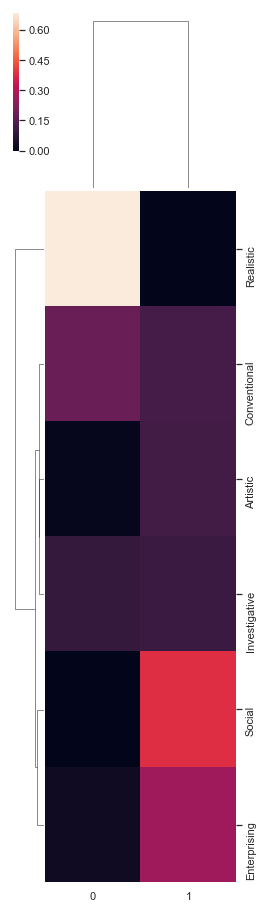

In [3]:
def plf(dd,n):
    sns.clustermap(OnetCluster(matrix(dd),n).fn.apply(lambda x: x**2).sort_values(
    1,axis=1,ascending = False).T,figsize=(2*n, 16),method = 'single')
plf(din,2)